# AI Assistance for Diagnostic Measurement

Neural network code for the *Non Destructive Diagnostic Measurement Methods for HF RFID Devices with AI Assistance* paper.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Uploading the data:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving All_data.csv to All_data.csv


Loading and printing the data:

In [3]:
filename = list(uploaded)[0]
df = pd.read_csv(filename)
df

,real,imag,status
0,58.753,-68.172,OK
1,61.165,-67.577,OK
2,58.887,-60.621,OK
3,70.496,-71.692,OK
4,39.165,-54.480,OK
...,...,...,...
111,35.062,-21.991,NB
112,190.203,185.721,NB
113,31.620,-25.903,NB
114,17.442,-34.589,NB


In [4]:
print(df["status"].value_counts())

KO    49
OK    46
NB    21
Name: status, dtype: int64


Optional: removing the KOs:

In [5]:
# df_OK = df.loc[df["status"] == "OK"]
# # df_KO = df.loc[df["status"] == "KO"]
# df_NB = df.loc[df["status"] == "NB"]
# df = pd.concat([df_OK, df_NB])
# df

Projecting the raw data in a Smith chart:

In [6]:
z = 50. # in ohm, reference value.
x, y = df["real"], df["imag"]
R = (x+z)*(x+z)+y*y
df_Smith = df.copy()
df_Smith["real"] = (x*x+y*y-z*z) / R
df_Smith["imag"] = 2.*z*y / R
df_Smith

,real,imag,status
0,0.339876,-0.413800,OK
1,0.343164,-0.399290,OK
2,0.298918,-0.390315,OK
3,0.387070,-0.364677,OK
4,0.183356,-0.498971,OK
...,...,...,...
111,-0.101961,-0.284889,NB
112,0.739447,0.201455,NB
113,-0.113082,-0.353249,NB
114,-0.173961,-0.602090,NB


Normalizing by global boundaries:

In [7]:
numericData = df[["real", "imag"]]
dataMin, dataMax = numericData.min(), numericData.max()
print("dataMin:\n", dataMin, "\n")
print("dataMax:\n", dataMax)

dataMin:
 real    -33.000
imag   -232.718
dtype: float64 

dataMax:
 real    709.874
imag    305.250
dtype: float64


In [8]:
df_nz = (df - dataMin) / (dataMax - dataMin)
df_nz["status"] = df["status"]
df_nz = df_nz[df.columns] # keeping the original column order
df = df_nz
df

,real,imag,status
0,0.123511,0.305866,OK
1,0.126758,0.306972,OK
2,0.123691,0.319902,OK
3,0.139318,0.299323,OK
4,0.097143,0.331317,OK
...,...,...,...
111,0.091620,0.391709,NB
112,0.300459,0.777814,NB
113,0.086986,0.384437,NB
114,0.067901,0.368291,NB


Drawing the data:

In [9]:
# Drawing the data, along with an optional heatmap:
def drawData(data, title, grid=[], heatmap=[]):
  fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
  if len(grid) != 0 and len(heatmap) != 0 and len(grid) == len(heatmap):
    ax.scatter(grid[:,0], grid[:,1], c=heatmap, alpha=0.3)
    title = "Heatmap - " + title
  colorMapping = { "OK": "red", "KO": "royalblue", "NB": "black" }
  for label, df_group in data.groupby("status"):
    ax.scatter(df_group["real"], df_group["imag"], c=df_group["status"].map(colorMapping), label=label)
  ax.legend(loc=(1.01, 0.5), title="status")
  plt.xlabel("real")
  plt.ylabel("imag")
  plt.title(title)
  plt.show()

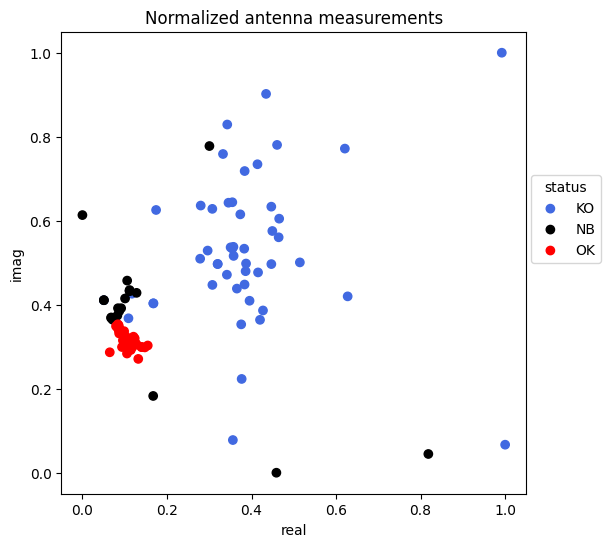

In [10]:
drawData(df, title="Normalized antenna measurements")

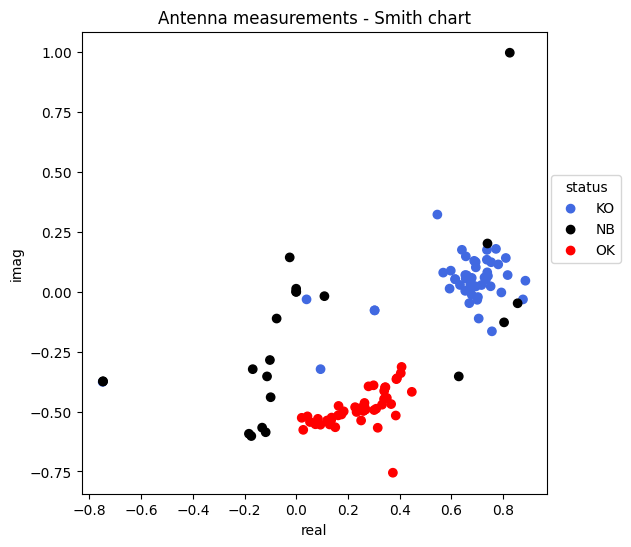

In [11]:
drawData(df_Smith, "Antenna measurements - Smith chart")

Model characteristics:

In [12]:
def buildModel():
  model = keras.Sequential([
    layers.Dense(50, activation="relu", input_shape=(None, 2)),
    layers.Dense(10, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
  ])

  model.compile(
    optimizer="Adam",
    loss="mean_squared_error",
    metrics=["accuracy"]
  )
  return model

In [13]:
model = buildModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 50)          150       
                                                                 
 dense_1 (Dense)             (None, None, 10)          510       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [14]:
def runTraining(data, seed, epochs=150):
  # Fixing the seeds, for reproducibility:
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.keras.utils.set_random_seed(seed)

  classMapping = { "OK": 0, "KO": 1, "NB": 1 } # binary classification
  data = data.replace({"status": classMapping}, inplace=False) # not modifying the original data.

  # Splitting the data evenly along each class:
  train, test = train_test_split(data, test_size = 0.5, random_state=seed, shuffle=True, stratify=data[["status"]])

  X_train, y_train = train[["real", "imag"]], train[["status"]]
  X_test, y_test = test[["real", "imag"]], test[["status"]]

  model = buildModel()

  # To save the best found model:
  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True
  )

  # Launching the learning:
  history = model.fit(
      x=X_train,
      y=y_train,
      batch_size=1,
      epochs=epochs,
      validation_data=(X_test, y_test),
      callbacks=[model_checkpoint_callback],
      verbose=0
  )

  # Loading the best model:
  model = keras.models.load_model("best_model.h5")

  # Stats computed on all data (train & test):
  X_all = np.concatenate([X_train, X_test])
  y_all = np.concatenate([y_train, y_test])
  total_loss, total_accuracy = model.evaluate(X_all, y_all, verbose=0)
  return seed, total_loss, total_accuracy, model, history

In [15]:
def runSearch(data, runs):
  start = time.time()
  results = {}
  for runIndex in tqdm(range(runs)):
    seed = runIndex # needs a different seed for each runIndex!
    results[runIndex] = runTraining(data, seed)
  end = time.time()
  print("Elapsed time: %.3f s" % (end - start))
  return results

In [16]:
results = runSearch(df, 100)

100%|██████████| 100/100 [58:33<00:00, 35.13s/it]

Elapsed time: 3513.281 s


In [17]:
results

{0: (0,
  0.0281666349619627,
  0.9913793206214905,
  <keras.callbacks.History at 0x7eff54ca7ac0>),
 1: (1,
  0.029140328988432884,
  0.9913793206214905,
  <keras.callbacks.History at 0x7eff437520b0>),
 2: (2,
  0.015169531106948853,
  1.0,
  <keras.callbacks.History at 0x7eff42883e80>),
 3: (3,
  0.025445949286222458,
  0.982758641242981,
  <keras.callbacks.History at 0x7eff52b0fd00>),
 4: (4,
  0.022197045385837555,
  0.9913793206214905,
  <keras.callbacks.History at 0x7eff42e7dde0>),
 5: (5,
  0.013930807821452618,
  1.0,
  <keras.callbacks.History at 0x7eff42e0f730>),
 6: (6,
  0.008032161742448807,
  1.0,
  <keras.callbacks.History at 0x7eff42be3d00>),
 7: (7,
  0.021906856447458267,
  0.9913793206214905,
  <keras.callbacks.History at 0x7eff4269fd00>),
 8: (8,
  0.029079746454954147,
  0.9741379022598267,
  <keras.callbacks.History at 0x7eff41496140>),
 9: (9,
  0.012122462503612041,
  0.9913793206214905,
  <keras.callbacks.History at 0x7eff41b1baf0>),
 10: (10,
  0.03549545630812

In [18]:
# Learning curves plotting:
def plotGraphs(title, history):
  if history != []:
    for string in ["loss", "accuracy"]:
      imgTitle = string.capitalize() + " - " + title
      plt.figure(figsize=(7, 5), dpi=85)
      plt.plot(history.history[string])
      plt.plot(history.history["val_"+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, "val_"+string])
      plt.title(imgTitle)
      plt.show()

In [19]:
# To show the neural net inference areas:
def drawRunResult(data, grid=[], title="", heatmap=[], runResult=[]):
  history, title = [], "%s for '%s' with KOs" % (title, filename)
  print(title)
  if runResult != []:
    seed, total_loss, total_accuracy, model, history = runResult
    print("Seed: %d\nTotal loss: %.6f\nTotal accuracy: %.2f %%" % (seed, total_loss, 100.*total_accuracy))
  # Drawing the heatmap:
  drawData(data, title, grid, heatmap)
  # Drawing the learning curves:
  plotGraphs(title, history)

In [20]:
# Showing the selected neural nets global stats, the inference areas and the learning curves:
def generateImages(data, results, steps=100, computeAverage=True):
  grid = np.array([ (i/steps, j/steps) for i in range(steps) for j in range(steps) ])
  runsData = sorted(results.values(), key=lambda x : x[1]) # best to worst total loss
  for title, idx in [("Best", 0), ("Median", len(results)//2), ("Worst", -1)]:
    drawRunResult(data, grid=grid, title=title, heatmap=runsData[idx][3].predict(grid, verbose=0), runResult=runsData[idx])
  if computeAverage:
    avgHeatmap = np.mean(np.array([ results[runIndex][3].predict(grid, verbose=0) for runIndex in results ]), axis=0)
    drawRunResult(data, grid=grid, title="Average", heatmap=avgHeatmap)

Best for 'All_data.csv' with KOs
Seed: 6
Total loss: 0.008032
Total accuracy: 100.00 %


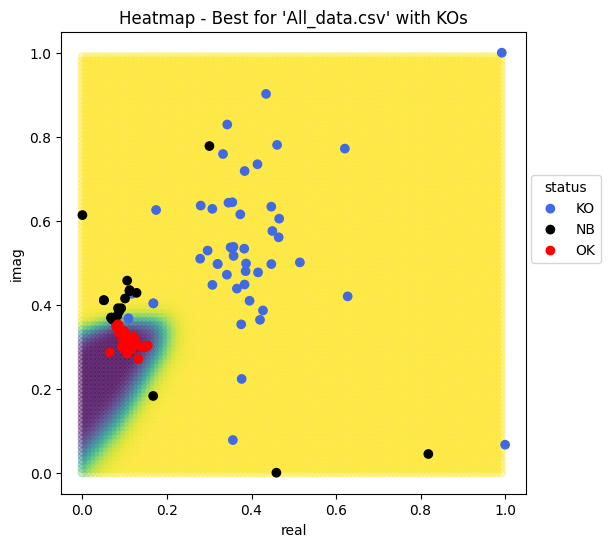

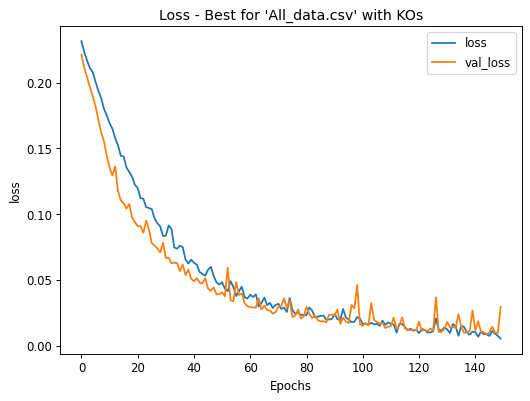

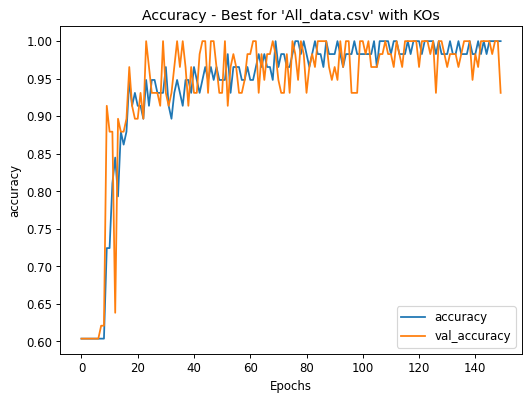

Median for 'All_data.csv' with KOs
Seed: 99
Total loss: 0.020390
Total accuracy: 100.00 %


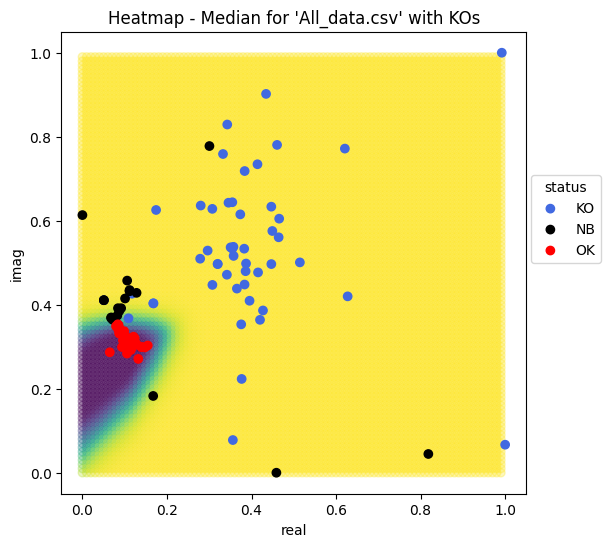

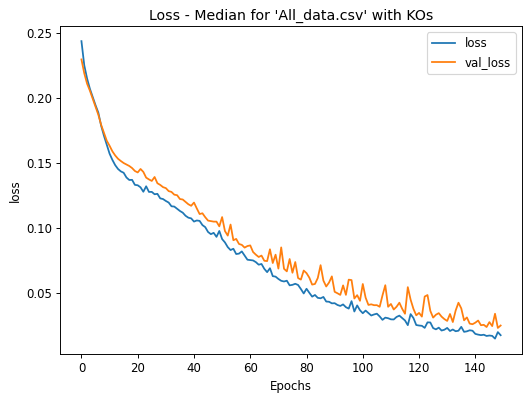

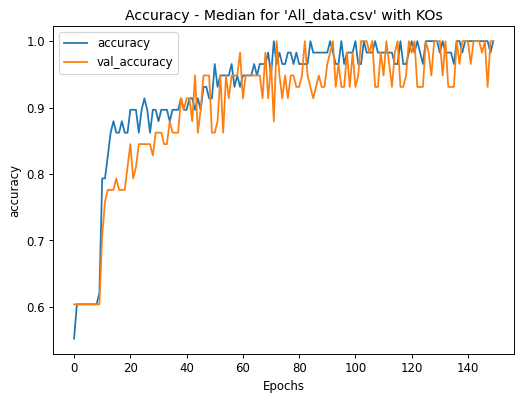

Worst for 'All_data.csv' with KOs
Seed: 70
Total loss: 0.045234
Total accuracy: 95.69 %


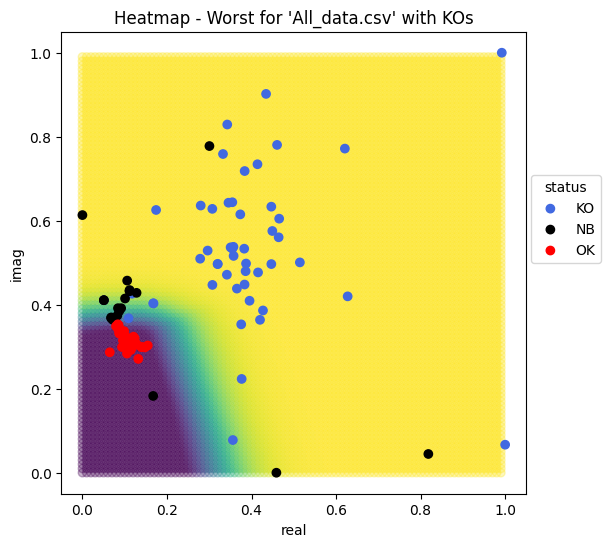

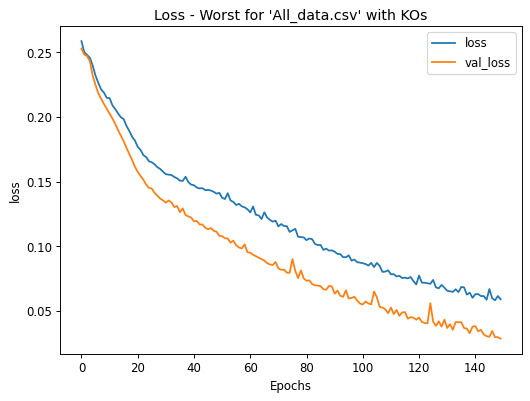

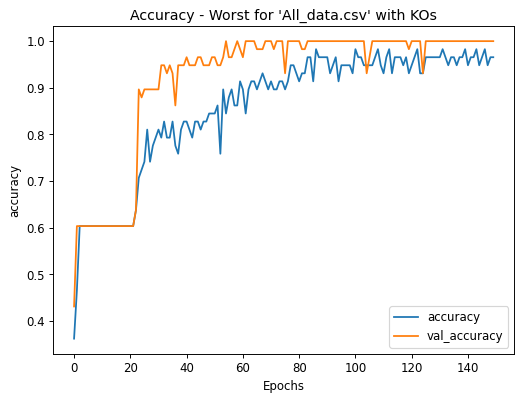

Average for 'All_data.csv' with KOs


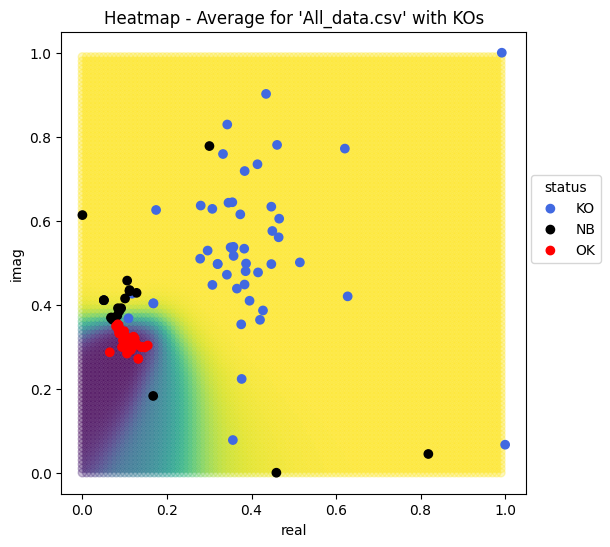

In [21]:
generateImages(df, results)